# Setup

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [37]:
import dill as pickle
from scipy import stats
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
pd.set_option('display.max_rows', 6)
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.transforms as mtransforms
plt.rcParams['figure.figsize'] = [16, 5]
pal = plt.get_cmap('Paired').colors

import altair as alt
alt.data_transformers.enable('json')
alt.renderers.enable('notebook')



from tqdm import tqdm, tqdm_notebook
import quandl

In [3]:
from utils import *

In [4]:
# api_key = open(file='quandl_api').read().replace('\n', '')
# quandl.ApiConfig.api_key = api_key

# tickers, prices = get_quandl_sharadar(free=True)
# prices = prices.assign(Set='free')

tickers, prices = get_sharadar_train()
prices = prices.query('Set == "train"')

In [5]:
print(len(tickers), 'assets in train set.')
prices

9010 assets in train set.


Open    High     Low  Close      Volume  Dividends  \
Ticker Date                                                              
A      1999-11-18  45.50  50.000  40.000  44.00  44739900.0        0.0   
       1999-11-19  42.94  43.000  39.810  40.38  10897100.0        0.0   
       1999-11-22  41.31  44.000  40.060  44.00   4705200.0        0.0   
       1999-11-23  42.50  43.630  40.250  40.25   4274400.0        0.0   
       1999-11-24  40.13  41.940  40.000  41.06   3464400.0        0.0   
...                  ...     ...     ...    ...         ...        ...   
ZYNE   2017-08-14   5.85   6.690   5.420   6.42   4253522.0        0.0   
       2017-08-15   6.31   6.570   6.067   6.24    925887.0        0.0   
       2017-08-16   6.20   7.000   6.040   6.36   1673477.0        0.0   
       2017-08-17   6.36   6.639   6.200   6.32    651837.0        0.0   
       2017-08-18   6.26   6.450   6.170   6.25    423696.0        0.0   

                   Closeunadj Lastupdated    Set  
Ticker Date                                       
A      1999-11-18       44.00  2018-02-11  train  
       1999-11-19       40.38  2018-02-11  train  
       1999-11-22       44.00  2018-02-11  train  
       1999-11-23       40.25  2018-02-11  train  
       1999-11-24       41.06  2018-02-11  train  
...                       ...         ...    ...  
ZYNE   2017-08-14        6.42  2017-11-01  train  
       2017-08-15        6.24  2017-11-01  train  
       2017-08-16        6.36  2017-11-01  train  
       2017-08-17        6.32  2017-11-01  train  
       2017-08-18        6.25  2017-11-01  train  

[14052292 rows x 9 columns]

In [6]:
ticker_days = prices.groupby('Ticker')[['Set']].count().rename(columns={'Set': 'n_days'}).reset_index()

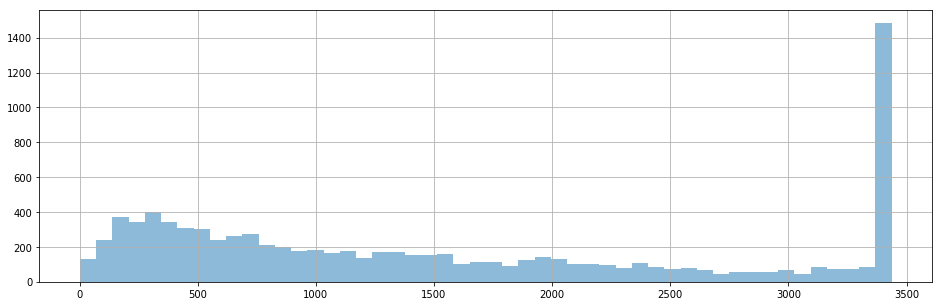

In [7]:
ticker_days.n_days.hist(bins=50, alpha=0.5)

# Finding the trend in a single price

See An introduction to smoothing time series in python, [part 1](http://www.nehalemlabs.net/prototype/blog/2013/04/05/an-introduction-to-smoothing-time-series-in-python-part-i-filtering-theory/) and [part 2](http://www.nehalemlabs.net/prototype/blog/2013/04/09/an-introduction-to-smoothing-time-series-in-python-part-ii-wiener-filter-and-smoothing-splines/).

In [ ]:
ticker = np.random.choice(tickers)
price = prices.loc[ticker]
print(len(price), 'days.')
price[['Open', 'High', 'Low', 'Close']].plot()
plt.title(ticker);

## Filters

In [ ]:
from scipy.interpolate import UnivariateSpline
from scipy.signal import wiener, filtfilt, butter, gaussian, freqz
from scipy.ndimage import filters
import scipy.optimize as op

### Linear 

In [ ]:
N = 61
f_sma = np.ones(N) / N

### Gaussian

In [ ]:
N_ga = 1500
f_ga = gaussian(N_ga, std=30.)
f_ga = f_ga / f_ga.sum()

In [ ]:
plt.figure(figsize=(7, 3))
plt.axhline(c='grey')
plt.axvline(c='grey')
plt.plot(np.arange(-N/2, N/2), f_sma, label='f_sma')
plt.plot(np.arange(-N_ga/2, N_ga/2), f_ga, label='f_ga')
plt.show()

### Geometric

In [ ]:
f_geo = lambda s: np.exp(filters.convolve1d(np.log(price.Close), f_ga))

### Wiener 

In [ ]:
sigma = np.std(price.Close)
f_wi = lambda x: wiener(x, mysize=N, noise=sigma)

### Spline

In [ ]:
f_sp = lambda x: UnivariateSpline(np.arange(len(x)), x)(np.arange(len(x)))

### Results

In [ ]:
plt.figure(figsize=(16, 6))
results = price[['Close']].assign(
    sma=filters.convolve1d(price.Close, f_sma),
    geo=f_geo(price.Close),
    ga=filters.convolve1d(price.Close, f_ga),
    ga2=filters.convolve1d(filters.convolve1d(price.Close, f_ga), f_ga),
    wi=f_wi(price.Close),
    sp=f_sp(price.Close),
)
results[:1000].plot(alpha=0.5);

In [ ]:
plt.figure(figsize=(16, 6));
results.plot(alpha = 0.5);

In [ ]:
def smooth_price(df, N=151, std=20.):
    f_ga = gaussian(N_ga, std=std)
    f_ga = f_ga / f_ga.sum()
    df = df.assign(Smoothed=filters.convolve1d(df.Close, f_ga))
    
    return df

## Trends 

### Peaks and Valleys

In [ ]:
from scipy.signal import find_peaks, find_peaks_cwt
from sklearn.metrics import confusion_matrix

In [ ]:
results = smooth_price(price)

In [ ]:
results

In [ ]:
results = results.assign(Trend=np.nan, Max_Drawdown=np.nan)
peaks, _ = find_peaks(results.Smoothed)
valleys, _ = find_peaks(-results.Smoothed)

In [ ]:
n_changes = min(len(peaks), len(valleys))
assert len(set(np.sign(peaks[:n_changes] - valleys[:n_changes]))) == 1

In [ ]:
# End
if valleys.max() > peaks.max():
    peaks = np.concatenate((peaks, np.ones(1, dtype=np.int32) * len(results) - 1))
else:
    valleys = np.concatenate((valleys, np.ones(1, dtype=np.int32) * len(results) - 1))

In [ ]:
peaks

In [ ]:
results.loc[results.index[peaks], 'Trend'] = 1
results.loc[results.index[valleys], 'Trend'] = -1
results.Trend.fillna(method='bfill', inplace=True)

In [ ]:
results

In [ ]:
fig, ax = plt.subplots(figsize=(16, 5))
trans = matplotlib.transforms.blended_transform_factory(ax.transData, ax.transAxes)
ax.fill_between(results.index, 0, results.Trend.max(), where= results.Trend > 0, facecolor=pal[0],
                        alpha=0.25, transform=trans, label='Trend up')
ax.fill_between(results.index, 0, results.Trend.max(), where= results.Trend < 0, facecolor=pal[4],
                alpha=0.25, transform=trans, label='Trend down')
plt.plot(results['Close'], alpha = 0.5)
plt.plot(results['Smoothed'], alpha = 0.5)
plt.plot(results.iloc[peaks]['Smoothed'], 'o', label='peaks')
plt.plot(results.iloc[valleys]['Smoothed'], 'o', label='valleys')
plt.axhline(0, c='grey')
plt.show()

### Slopes

In [ ]:
results = results.assign(Trend2=results.Smoothed.pct_change().apply(np.sign))
results.loc[results.index[0], 'Trend2'] = results.Trend2[1]

In [ ]:
fig, ax = plt.subplots(figsize=(16, 5))
trans = matplotlib.transforms.blended_transform_factory(ax.transData, ax.transAxes)
ax.fill_between(results.index, 0, results.Trend2.max(), where= results.Trend2 > 0, facecolor=pal[0],
                        alpha=0.25, transform=trans, label='Trend2 up')
ax.fill_between(results.index, 0, results.Trend2.max(), where= results.Trend2 < 0, facecolor=pal[4],
                alpha=0.25, transform=trans, label='Trend2 down')
plt.plot(results['Close'], alpha = 0.5)
plt.plot(results['Smoothed'], alpha = 0.5)
plt.plot(results.iloc[peaks]['Smoothed'], 'o', label='peaks')
plt.plot(results.iloc[valleys]['Smoothed'], 'o', label='valleys')
plt.axhline(0, c='grey')
plt.show()

In [ ]:
confusion_matrix(results.Trend.values, results.Trend2) / len(results)

> Both methods are equivalent!!

## Max drawdown within trend

-> For trailing stop-loss orders...

In [ ]:
breakpoints = np.concatenate((np.zeros(1, dtype=np.int32), peaks + 1, valleys + 1))
breakpoints.sort()
print('Breakpoints:', breakpoints)

In [ ]:
b = 3
trend_start = breakpoints[b - 1]
trend_end = breakpoints[b]
res_b = results[trend_start:trend_end]
res_b

In [ ]:
for b in range(1, len(breakpoints)):

    trend_start = breakpoints[b - 1]
    trend_end = breakpoints[b]
    res_b = results[trend_start:trend_end]
    trend_b = res_b.Trend[0]

    # Adjust for position (long, short)
    close_b = res_b.Close[0] * res_b.Close.pct_change()[1:].mul(trend_b).add(1).cumprod()  
    close_b[res_b.index[0]] = res_b.Close[0]
    close_b = close_b.sort_index()

    peak = close_b[0]
    low = peak
    drawdown = 0
    max_drawdown = 0

    for i in range(1, len(close_b)):
        # Max drawdown
        if close_b[i] > peak:
            peak = close_b[i]
            low = peak
        if close_b[i] < low:
            low = close_b[i]
            drawdown = low / peak - 1
        max_drawdown = min(drawdown, max_drawdown)
    
    results.loc[res_b.index, 'Max_Drawdown'] = -max_drawdown
    

In [ ]:
results

In [ ]:
fig, ax = plt.subplots(figsize=(16, 5))
trans = matplotlib.transforms.blended_transform_factory(ax.transData, ax.transAxes)
ax.fill_between(results.index, 0, results.Trend.max(), where= results.Trend > 0, facecolor=pal[0],
                        alpha=0.25, transform=trans, label='Trend up')
ax.fill_between(results.index, 0, results.Trend.max(), where= results.Trend < 0, facecolor=pal[4],
                alpha=0.25, transform=trans, label='Trend down')
plt.plot(results.Close, label='Close')
plt.plot(results.Smoothed, label='Smoothed')
plt.plot(results.Close * (1 - results.Max_Drawdown * results.Trend), label='Stop-loss')
plt.axhline(0, c='grey')
plt.legend()
plt.title(ticker)
plt.show()

In [ ]:
res2 = find_trends(price)
plot_trends(res2)

# Sample...

## A single asset 

In [8]:
from utils import *

In [9]:
ticker = np.random.choice(tickers)
# ticker = 'TFCO'
price = prices.loc[ticker]
print(len(price), 'days.')

3437 days.


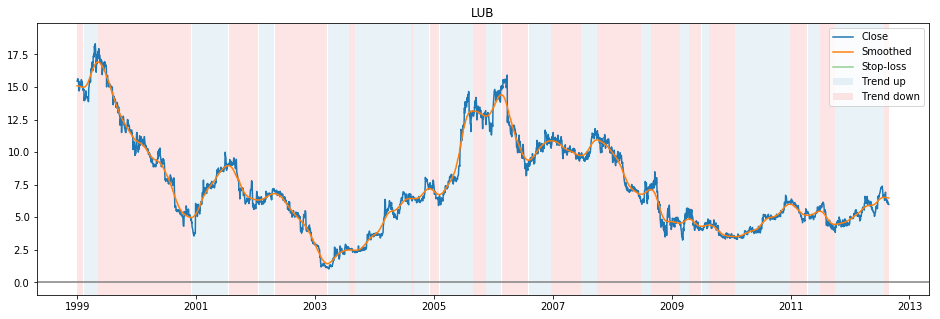

In [10]:
trends = find_trends(price, sd=20.)
plot_trends(trends, ticker)

In [11]:
trends

,Open,High,Low,Close,Volume,Dividends,Closeunadj,Lastupdated,Set,Smoothed,Trend,n_Trend,Max_Drawdown,Ratio,ICAGR,Bliss,Trend_Start,Trend_End
Date,,,,,,,,,,,,,,,,,,
1998-12-31,15.38,15.750,15.19,15.44,73300.0,0.0,15.44,2018-02-11,train,15.084942,-1.0,1.0,0.053737,1.036269,0.360478,6.708201,1998-12-31,1999-02-05
1999-01-04,15.19,15.750,15.19,15.63,49700.0,0.0,15.63,2018-02-11,train,15.083782,-1.0,1.0,NaN,NaN,NaN,NaN,1998-12-31,1999-02-05
1999-01-05,15.81,16.000,15.50,15.56,28200.0,0.0,15.56,2018-02-11,train,15.081862,-1.0,1.0,NaN,NaN,NaN,NaN,1998-12-31,1999-02-05
1999-01-06,15.63,15.630,15.13,15.56,47100.0,0.0,15.56,2018-02-11,train,15.079205,-1.0,1.0,NaN,NaN,NaN,NaN,1998-12-31,1999-02-05
1999-01-07,15.50,15.630,15.38,15.50,51000.0,0.0,15.50,2018-02-11,train,15.075838,-1.0,1.0,NaN,NaN,NaN,NaN,1998-12-31,1999-02-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-08-21,6.21,6.269,6.10,6.14,29200.0,0.0,6.14,2017-11-01,train,6.487630,-1.0,33.0,NaN,NaN,NaN,NaN,2012-07-30,2012-08-27
2012-08-22,6.13,6.330,6.12,6.14,9000.0,0.0,6.14,2017-11-01,train,6.486085,-1.0,33.0,NaN,NaN,NaN,NaN,2012-07-30,2012-08-27
2012-08-23,6.11,6.130,6.00,6.00,54400.0,0.0,6.00,2017-11-01,train,6.484963,-1.0,33.0,NaN,NaN,NaN,NaN,2012-07-30,2012-08-27


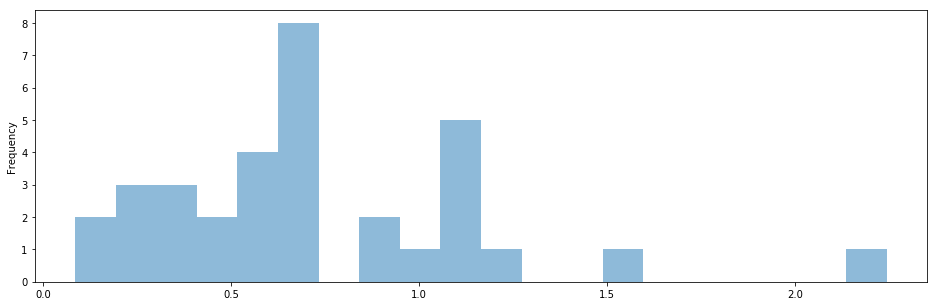

In [16]:
trends.groupby('n_Trend').first().ICAGR.plot.hist(bins=20, alpha=0.5)

In [ ]:
trends.groupby('n_Trend').Trend.count()

In [ ]:
summarise_trends(price, sd=20)

In [ ]:
trends2 = find_trends(price, sd=5.)
plot_trends(trends2, ticker)

In [ ]:
summarise_trends(price, sd=5)

In [ ]:
sds = np.arange(5, 250, step=5)
sum_trends = pd.concat([summarise_trends(price, s) for s in sds], axis=0)

In [ ]:
sum_trends

In [ ]:
sum_trends.set_index('sd')[['mean', 'min', '50%', 'max']].plot();

In [ ]:
sum_trends.set_index('sd')[['trend_freq']].plot();

In [ ]:
sum_trends.set_index('sd')[['ICAGR', 'mean_ICAGR', 'neg_ICAGR']].plot();

In [ ]:
sum_trends.set_index('sd')[['Bliss']].plot();

## Multiple assets

### Single thread

In [ ]:
from utils import *
# summarise_trends(prices.loc['A'], sd=100)
# results = pickle.load(open('output/Finding the trends - sd values for filtering.pickle', 'rb'))

In [ ]:
# n_tickers = 1000
sds = np.arange(5, 300, step=5)

results = []
# grouped = prices.loc[np.random.choice(tickers, size=n_tickers)].groupby('Ticker')
grouped = prices.groupby('Ticker')
# grouped = prices.loc[list(set(results_df.Ticker.values))].groupby('Ticker')

for name, group in tqdm_notebook(grouped, desc='Ticker:'):
    res_g = []
    for s in tqdm_notebook(sds, desc='sd:', leave=False, postfix=dict(n_days=str(len(group)))):
        try:
            res_g.append(summarise_trends(group.reset_index('Ticker'), s))
        except:
            pass
    try:
        results.append(pd.concat(res_g, axis=0).assign(Ticker=name))
    except:
        pass

In [ ]:
# pickle.dump(results, open('output/Finding the trends - std values for filtering.pickle', 'wb'))

### Results

In [ ]:
results = pickle.load(open('output/Finding the trends - std values for filtering.pickle', 'rb'))

In [ ]:
results_df = pd.concat(results, axis=0, sort=True)
# results_df = results_df.query('n_days > 3 * sd')
results_df = results_df.set_index('Ticker').loc[np.random.choice(results_df.Ticker.values, size=500)]
results_df = results_df.reset_index().query('n_days > 3 * sd')
results_df

####  ICAGR

In [ ]:
alt.Chart(results_df.reset_index()).mark_line(point=True, opacity=0.25).encode(
    x='sd',
    y='ICAGR',
    color=alt.Color('Ticker', legend=None),
    size='n_days',
    tooltip=['Ticker', 'max', 'min', '50%', 'mean', 'count', 'n_days', 'sd']
).properties(width=800, height=300).interactive()

In [ ]:
line = alt.Chart(results_df.reset_index()).mark_line().encode(
    x='sd',
    y='mean(ICAGR)'
)
confidence_interval = alt.Chart(results_df.reset_index()).mark_area(opacity=0.5).encode(
    x='sd',
    y=alt.Y('ci0(ICAGR)', axis=alt.Axis(title='ICAGR')),
    y2='ci1(ICAGR)',
)
total_interval = alt.Chart(results_df.reset_index()).mark_area(opacity=0.1).encode(
    x='sd',
    y=alt.Y('min(ICAGR)', axis=alt.Axis(title='ICAGR')),
    y2='max(ICAGR)',
).properties(width=800, height=300).interactive()
total_interval + confidence_interval + line

#### Max Drawdown

In [ ]:
alt.Chart(results_df.reset_index()).mark_line(point=True, opacity=0.25).encode(
    x='sd',
    y='Max_Drawdown',
    color=alt.Color('Ticker', legend=None),
    size='n_days',
    tooltip=['Ticker', 'max', 'min', '50%', 'mean', 'count', 'n_days', 'sd']
).properties(width=800, height=300).interactive()

In [ ]:
line = alt.Chart(results_df.reset_index()).mark_line().encode(
    x='sd',
    y='mean(Max_Drawdown)'
).properties(width=800, height=300).interactive()
confidence_interval = alt.Chart(results_df.reset_index()).mark_area(opacity=0.5).encode(
    x='sd',
    y=alt.Y('ci0(Max_Drawdown)', axis=alt.Axis(title='Max_Drawdown')),
    y2='ci1(Max_Drawdown)',
)
total_interval = alt.Chart(results_df.reset_index()).mark_area(opacity=0.1).encode(
    x='sd',
    y=alt.Y('min(Max_Drawdown)', axis=alt.Axis(title='Max_Drawdown')),
    y2='max(Max_Drawdown)',
)
# total_interval + 
confidence_interval + line

#### Bliss

In [ ]:
alt.Chart(results_df.reset_index()).mark_line(point=True, opacity=0.5).encode(
    x='sd',
    y='Bliss',
    color=alt.Color('Ticker', legend=None),
    size='n_days',
    tooltip=['Ticker', 'max', 'min', '50%', 'mean', 'count', 'n_days']
).properties(
    width=800,
    height=300
).interactive()

In [ ]:
line = alt.Chart(results_df.reset_index()).mark_line().encode(
    x='sd',
    y='mean(Bliss)'
).properties(width=800, height=300).interactive()
confidence_interval = alt.Chart(results_df.reset_index()).mark_area(opacity=0.5).encode(
    x='sd',
    y=alt.Y('ci0(Bliss)', axis=alt.Axis(title='Bliss')),
    y2='ci1(Bliss)',
)
total_interval = alt.Chart(results_df.reset_index()).mark_area(opacity=0.1).encode(
    x='sd',
    y=alt.Y('min(Bliss)', axis=alt.Axis(title='Bliss')),
    y2='max(Bliss)',
)
# total_interval + 
confidence_interval + line

#### Error frequency

In [ ]:
line = alt.Chart(results_df.reset_index(), title='Number of negative ratios / number of trends').mark_line().encode(
    x='sd',
    y='mean(neg_freq)'
).properties(width=800, height=300).interactive()
confidence_interval = alt.Chart(results_df.reset_index()).mark_area(opacity=0.5).encode(
    x='sd',
    y=alt.Y('ci0(neg_freq)', axis=alt.Axis(title='neg_freq')),
    y2='ci1(neg_freq)',
)
total_interval = alt.Chart(results_df.reset_index()).mark_area(opacity=0.1).encode(
    x='sd',
    y=alt.Y('min(neg_freq)', axis=alt.Axis(title='neg_freq')),
    y2='max(neg_freq)',
)
# total_interval + 
confidence_interval + line

In [ ]:
alt.Chart(results_df.assign(Color = results_df.neg_ICAGR > 0).reset_index()).mark_area(opacity=0.25).encode(
    x='sd',
    y=alt.Y('count()'),
    color=alt.Color('Color', title='neg_ICAGR'),
#     size='sd',
#     tooltip=['Ticker', 'max', 'min', '50%', 'mean', 'count', 'n_days', 'sd', 'ICAGR', 'neg_ICAGR']
).properties(
    width=800,
    height=200
).interactive()

In [ ]:
alt.Chart(results_df.assign(neg_ICAGR = results_df.neg_ICAGR.astype(str)).reset_index()).mark_area(opacity=0.25).encode(
    x='sd',
    y=alt.Y('count()'),
    color=alt.Color('neg_ICAGR', title='neg_ICAGR',
                    scale=alt.Scale(domain=[str(i) for i in np.arange(11)])),
#     size='sd',
#     tooltip=['Ticker', 'max', 'min', '50%', 'mean', 'count', 'n_days', 'sd', 'ICAGR', 'neg_ICAGR']
).properties(
    width=800,
    height=200
).interactive()

#### Trend frequency and duration

In [ ]:
alt.Chart(results_df).mark_line(point=True, opacity=0.5).encode(
    x='sd',
    y=alt.Y('trend_freq', scale=alt.Scale(type='log')), #y='trend_freq',
    color=alt.Color('Ticker', legend=None),
    size='n_days',
    tooltip=['Ticker', 'max', 'min', '50%', 'mean', 'count', 'n_days']
).properties(
    width=800,
    height=200
).interactive()

In [ ]:
alt.Chart(results_df, title='Trend duration (days)').mark_line(point=True, opacity=0.5).encode(
    x='sd',
    y=alt.Y('mean', scale=alt.Scale(type='log')), #y='trend_freq',
    color=alt.Color('Ticker', legend=None),
    size='n_days',
    tooltip=['Ticker', 'max', 'min', '50%', 'mean', 'count', 'n_days']
).properties(
    width=800,
    height=200
).interactive()

## Lab

### Ideal System (that cheats...)

In [796]:
from trading_strategies import *
from utils import *

In [797]:
# ticker = np.random.choice(results_df.Ticker)  
ticker = np.random.choice(tickers)
# ticker = 'VRX1'
price = prices.loc[ticker]
print(ticker, len(price), 'days.')

SPNS 3437 days.


In [798]:
price.isna().sum()

Open           0
High           0
Low            0
              ..
Closeunadj     0
Lastupdated    0
Set            0
Length: 9, dtype: int64

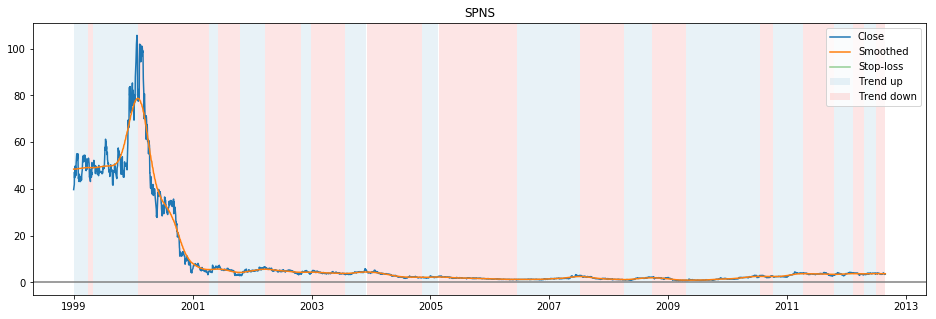

In [799]:
trends = find_trends(price, sd=30)
plot_trends(trends, ticker)

In [800]:
trends.groupby('n_Trend').first().iloc[5:].head(6)

,Open,High,Low,Close,Volume,Dividends,Closeunadj,Lastupdated,Set,Smoothed,Trend,Max_Drawdown,ATR,max_TR,min_TR,Ratio,ICAGR,Bliss,Trend_Start,Trend_End
n_Trend,,,,,,,,,,,,,,,,,,,,
6.0,7.20,7.20,6.80,6.800,3600.0,0.0,1.360,2017-11-01,train,5.717743,-1.0,0.119718,0.080551,0.716667,0.000000,1.485294,1.091682,9.118752,2001-06-08,2001-10-18
7.0,3.60,3.60,3.25,3.300,53900.0,0.0,0.660,2017-11-01,train,4.280130,1.0,0.228070,0.082438,0.191304,0.020202,1.939394,1.587304,6.959720,2001-10-19,2002-03-20
8.0,6.50,6.60,6.30,6.600,7200.0,0.0,1.320,2017-11-01,train,5.675833,-1.0,0.097701,0.075227,0.275510,0.000000,1.401515,0.556353,5.694436,2002-03-21,2002-10-28
9.0,3.95,3.95,3.50,3.750,2600.0,0.0,0.750,2017-11-01,train,4.341826,1.0,0.313725,0.106396,0.377778,0.022222,1.053333,0.320785,1.022503,2002-10-29,2002-12-27
10.0,3.60,3.90,3.30,3.900,13200.0,0.0,0.780,2017-11-01,train,4.431613,-1.0,0.320513,0.079357,0.625000,0.000000,1.082051,0.138764,0.432945,2002-12-30,2003-07-25
11.0,3.47,3.73,3.47,3.651,2800.0,0.0,3.651,2017-11-01,train,3.842955,1.0,0.124675,0.054417,0.114726,0.000000,1.421528,0.993167,7.966030,2003-07-28,2003-12-04


In [801]:
cheat_ts = Oracle_Trading_Strategy(price, equity=1e6, name=ticker, #heat=0.63,
                                   trend=trends.Trend.values,
                                   max_dd= trends.ATR.fillna(method='ffill').values + \
                                           trends.Max_Drawdown.fillna(method='ffill').values)
cheat_ts.excecute(warmup=1)

In [802]:
cheat_ts.performance

{'Years': 13.682910089224434,
 'Ratio': 3.811617914886547,
 'ICAGR': 0.09779014404477898,
 'Max_Drawdown': 0.17665723820023138,
 'Bliss': 0.5535586599284382,
 'Lake_Ratio': 0.06498315444209084,
 'Sea_Ratio': 0.11981506389699334}

In [803]:
trades_profit = cheat_ts.get_trades_profit()
trades_profit.head(3)

,transaction,Entry Date,Entry Price,Amount,transaction,Exit Date,Exit Price,PL,PL_pct
0,0,1999-01-04,41.875,4420.0,1,1999-03-31,52.500000,46962.500000,0.253731
1,2,1999-04-05,51.575,-5202.0,3,1999-04-23,51.983838,-2126.774475,-0.007927
2,4,1999-04-30,49.700,-2714.0,5,1999-05-03,50.950000,-3392.500000,-0.025151


In [804]:
cheat_ts.get_trades_profit().tail(6)

,transaction,Entry Date,Entry Price,Amount,transaction,Exit Date,Exit Price,PL,PL_pct
53,106,2011-08-19,3.685,-156430.0,107,2011-10-17,3.528356,24503.762354,0.042508
54,108,2011-10-19,3.215,141426.0,109,2012-02-14,3.870000,92634.030000,0.203733
55,110,2012-02-17,3.870,-291088.0,111,2012-03-27,3.556640,91215.448495,0.080972
56,112,2012-04-02,3.510,-338278.0,113,2012-04-23,3.520000,-3382.780000,-0.002849
57,114,2012-05-01,3.520,391927.0,115,2012-07-02,3.631000,43503.897000,0.031534
58,116,2012-07-06,3.845,-232439.0,117,2012-08-27,3.570000,63920.725000,0.071521


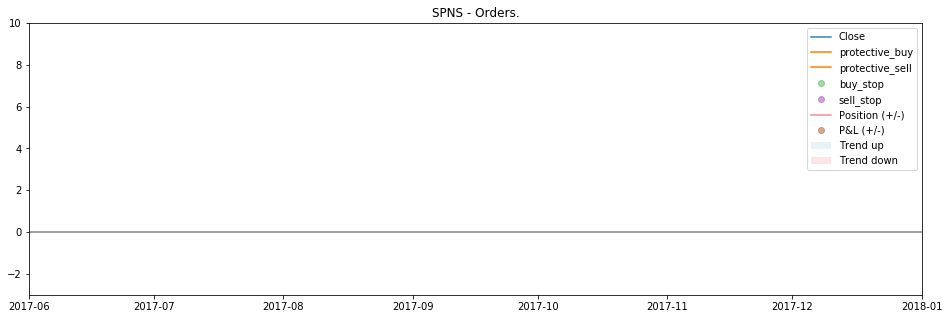

In [805]:
cheat_ts.plot_orders()
plt.xlim((datetime(2017, 6, 1), datetime(2018, 1, 1)));
plt.ylim((-3, 10));

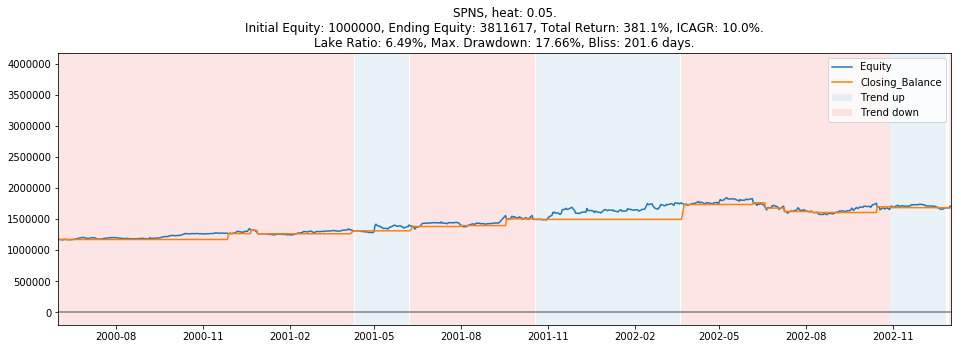

In [806]:
cheat_ts.plot_equity()
plt.xlim((datetime(2000, 6, 1), datetime(2003, 1, 1)));
# plt.ylim((-10, 50));

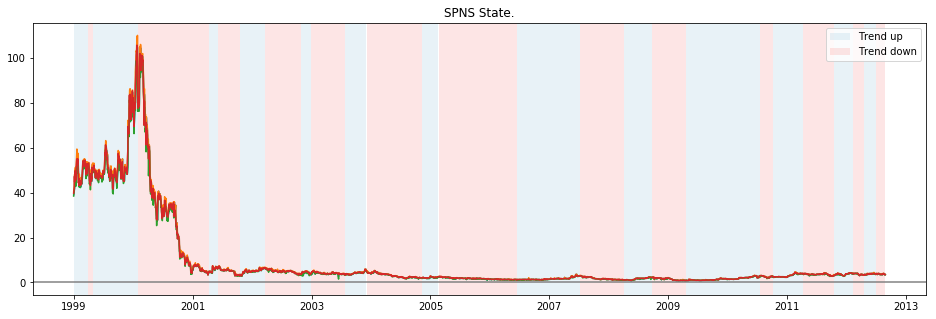

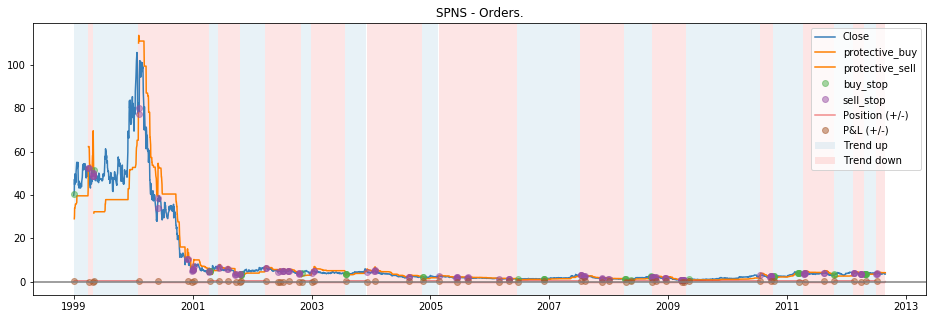

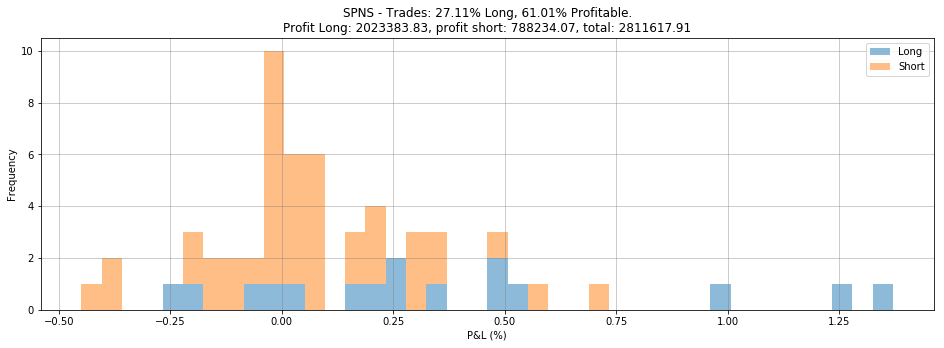

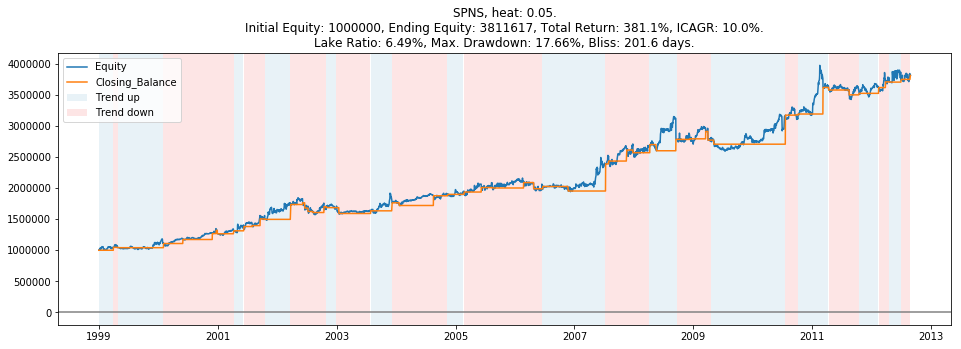

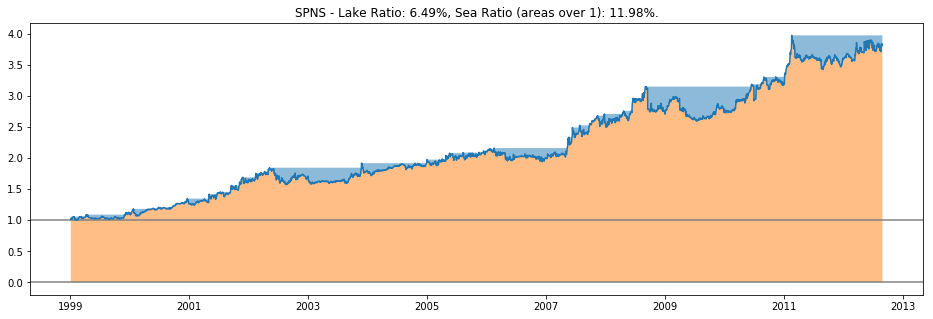

In [807]:
cheat_ts.plot_state()
cheat_ts.plot_orders()
cheat_ts.plot_trades()
cheat_ts.plot_equity()
cheat_ts.plot_lake_ratio()

### Lag vs sd

In [413]:
from joblib import Parallel, delayed

In [414]:
def get_performance(sd, lag=0, heat=0.05):
    
    tr = find_trends(price, sd)
    trend = tr.Trend.shift(lag).fillna(value=0)
    
    ch_ts = Oracle_Trading_Strategy(price, equity=1e6, name=ticker, 
                                    heat=heat,
                                    trend=trend,
                                    max_dd=tr.ATR.fillna(method='ffill').values + \
                                           tr.Max_Drawdown.fillna(method='ffill').values)
    ch_ts.excecute(warmup=1)
    
    return {'sd': sd, 'lag':lag, 'heat': heat, **ch_ts.performance}

In [717]:
lags = np.concatenate((np.arange(0, 20, 5), np.arange(20, 41, 5)))
sds = np.concatenate((np.arange(5, 40, 2.5), np.arange(40, 81, 5)))
heats = np.arange(0.025, 0.81, step=0.025)

print('Lags: ', len(lags), ', sds: ', len(sds), ', heats: ', len(heats),
      '.\nSteps: ', len(lags) * len(sds) * len(heats), sep='')
print('')
print('lags:', lags)
print('sds:', sds)
print('heats:', heats)

Lags: 9, sds: 23, heats: 32.
Steps: 6624

lags: [ 0  5 10 15 20 25 30 35 40]
sds: [ 5.   7.5 10.  12.5 15.  17.5 20.  22.5 25.  27.5 30.  32.5 35.  37.5
 40.  45.  50.  55.  60.  65.  70.  75.  80. ]
heats: [0.025 0.05  0.075 0.1   0.125 0.15  0.175 0.2   0.225 0.25  0.275 0.3
 0.325 0.35  0.375 0.4   0.425 0.45  0.475 0.5   0.525 0.55  0.575 0.6
 0.625 0.65  0.675 0.7   0.725 0.75  0.775 0.8  ]


In [718]:
perf = Parallel(-1, verbose=10)(
    delayed(get_performance)(s, l, h)
    for s, l, h in itertools.product(sds, lags, heats))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   34.0s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   41.6s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   45.9s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   52.7s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   58.3s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  1

In [714]:
perf_df = pd.concat([DataFrame(Series(p)).transpose() for p in perf], axis=0)
perf_df = perf_df.assign(
    heat = np.round(perf_df.heat.values, 2),
    sd = np.round(perf_df.sd.values, 1),
    ICAGR = np.clip(perf_df.ICAGR.values, -20, None),
    Bliss = np.clip(perf_df.Bliss.values, -20, None),
)
perf_df

,sd,lag,heat,Years,Ratio,ICAGR,Max_Drawdown,Bliss,Lake_Ratio,Sea_Ratio
0,5.0,0.0,0.02,5.306795,4.865854,0.298154,0.044048,6.768879,0.008983,0.015153
0,5.0,0.0,0.05,5.306795,21.884102,0.581473,0.081455,7.138622,0.016633,0.019400
0,5.0,0.0,0.08,5.306795,91.778663,0.851621,0.113759,7.486210,0.023862,0.025020
...,...,...,...,...,...,...,...,...,...,...
0,80.0,40.0,0.55,5.306795,4.630883,0.288827,0.924369,0.312459,0.727095,1.454865
0,80.0,40.0,0.58,5.306795,4.167360,0.268954,0.939396,0.286305,0.855264,1.892457
0,80.0,40.0,0.60,5.306795,3.630451,0.242963,0.952796,0.255000,1.036083,2.683716


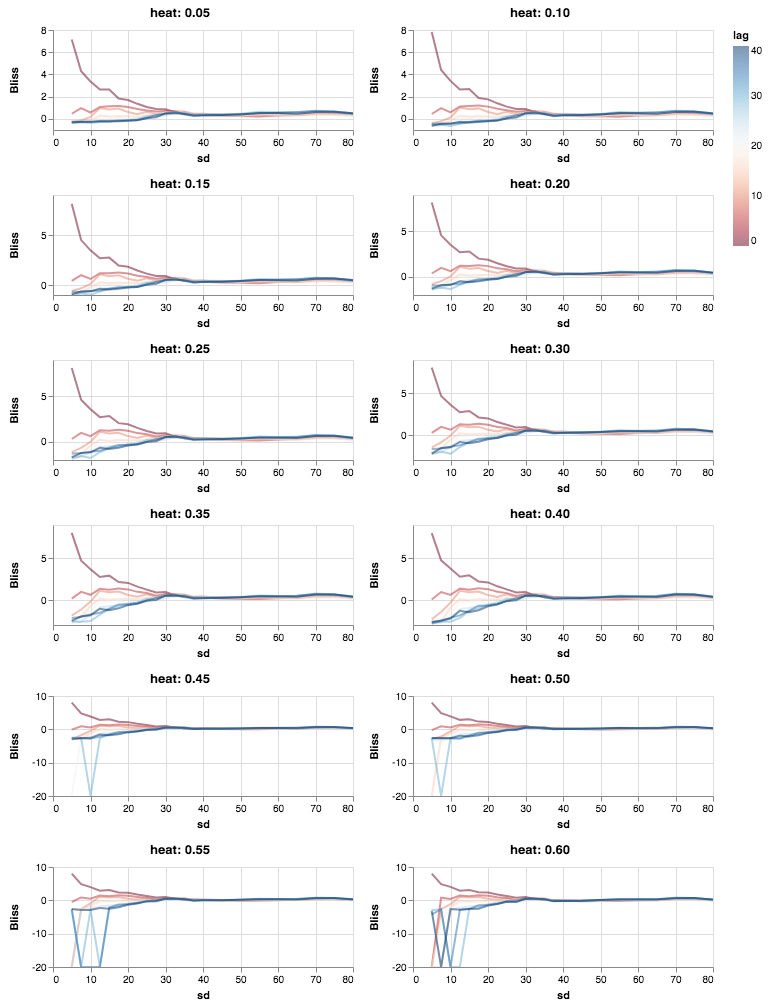

In [737]:
from altair.expr import datum
base = alt.Chart(
    perf_df,
    title=ticker,
    
).mark_line(
    opacity=0.5,
    point=False
).encode(
    x='sd',
    y='Bliss',
    color=alt.Color('lag', scale=alt.Scale(scheme='redblue')),
    tooltip=['sd', 'lag', 'ICAGR', 'Bliss']
).properties(width=300, height=100).interactive()

alt.vconcat(
    base.properties(title='heat: 0.05').transform_filter(datum.heat==0.05) |
    base.properties(title='heat: 0.10').transform_filter(datum.heat==0.10),
    base.properties(title='heat: 0.15').transform_filter(datum.heat==0.15) |
    base.properties(title='heat: 0.20').transform_filter(datum.heat==0.20),
    base.properties(title='heat: 0.25').transform_filter(datum.heat==0.25) |
    base.properties(title='heat: 0.30').transform_filter(datum.heat==0.30),
    base.properties(title='heat: 0.35').transform_filter(datum.heat==0.35) |
    base.properties(title='heat: 0.40').transform_filter(datum.heat==0.40),
    base.properties(title='heat: 0.45').transform_filter(datum.heat==0.45) |
    base.properties(title='heat: 0.50').transform_filter(datum.heat==0.50),
    base.properties(title='heat: 0.55').transform_filter(datum.heat==0.55) |
    base.properties(title='heat: 0.60').transform_filter(datum.heat==0.60),
)

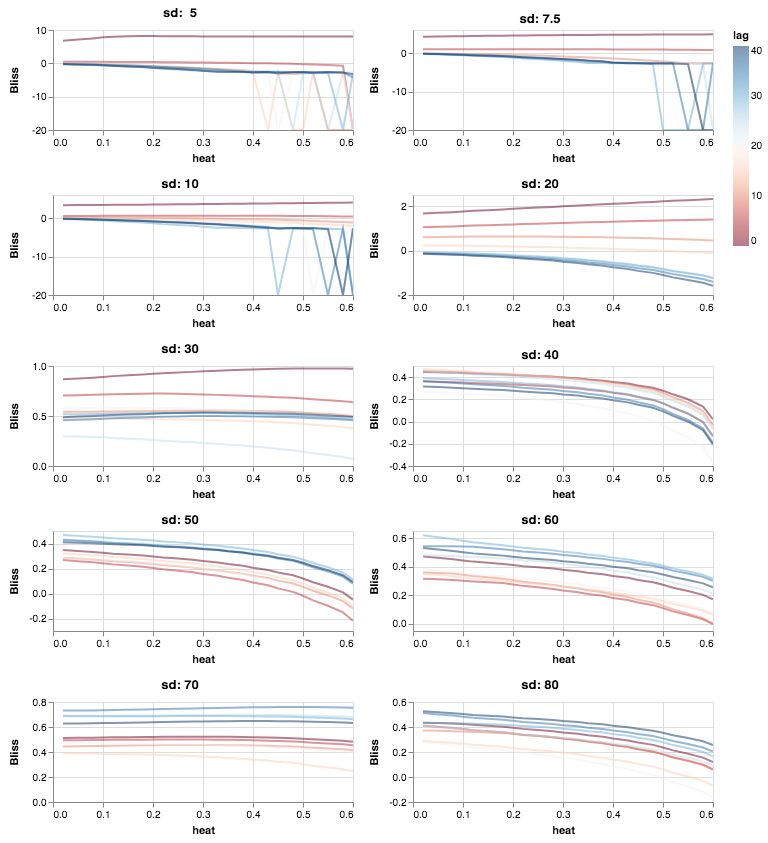

In [738]:
from altair.expr import datum
base = alt.Chart(
    perf_df,
    title=ticker
).mark_line(
    opacity=0.5,
    point=False
).encode(
    x='heat',
    y='Bliss',
    color=alt.Color('lag', scale=alt.Scale(scheme='redblue')),
    tooltip=['heat', 'sd', 'lag', 'ICAGR', 'Bliss']
).properties(width=300, height=100).interactive()

alt.vconcat(
    base.properties(title='sd:  5').transform_filter(datum.sd==5) |
    base.properties(title='sd: 7.5').transform_filter(datum.sd==7.5),
    base.properties(title='sd: 10').transform_filter(datum.sd==10) |
    base.properties(title='sd: 20').transform_filter(datum.sd==20),
    base.properties(title='sd: 30').transform_filter(datum.sd==30) |
    base.properties(title='sd: 40').transform_filter(datum.sd==40),
    base.properties(title='sd: 50').transform_filter(datum.sd==50) |
    base.properties(title='sd: 60').transform_filter(datum.sd==60),
    base.properties(title='sd: 70').transform_filter(datum.sd==70) |
    base.properties(title='sd: 80').transform_filter(datum.sd==80),
)

## Trades distribution

In [739]:
n_tickers = 100

trades = []
grouped = prices.loc[np.random.choice(tickers, size=n_tickers)].groupby('Ticker')
# grouped = prices.groupby('Ticker')
# grouped = prices.loc[list(set(trades_df.Ticker.values))].groupby('Ticker')

for name, group in tqdm_notebook(grouped, desc='Ticker:'):
    
    tr = find_trends(group.reset_index('Ticker'), 35)
    trend = tr.Trend.shift(20).fillna(value=0)
    
    cheat_ts = Oracle_Trading_Strategy(
                   group.reset_index('Ticker'),
                   equity=1e6, name=name,
                   trend=tr.Trend.values,
                   max_dd=tr.Max_Drawdown.fillna(method='ffill').values + \
                          tr.Max_Drawdown.fillna(method='ffill').values,
    )
    cheat_ts.excecute(warmup=1)
    try:
        trades.append(cheat_ts.get_trades_profit().assign(Ticker=name))
    except:
        pass

/Users/juanpabloacosta/GitHub/trend-following/trading_strategies.py:339: RuntimeWarning: divide by zero encountered in log
  # Instantaneously Compounding Annual Gain
/Users/juanpabloacosta/GitHub/trend-following/utils.py:341: RuntimeWarning: divide by zero encountered in double_scalars
  drawdown = low / peak - 1


In [740]:
trades_df = pd.concat(trades, axis=0)
DataFrame(trades_df.PL_pct.agg(['min', 'max', 'mean', 'std',
                                'skew', 'kurtosis', 'count'])).transpose()

,min,max,mean,std,skew,kurtosis,count
PL_pct,-12.333333,41.349796,0.286219,1.494189,16.216502,393.709722,1716.0


In [741]:
trades_df.sort_values('PL_pct')

,transaction,Entry Date,Entry Price,Amount,transaction,Exit Date,Exit Price,PL,PL_pct,Ticker
6,12,2014-08-21,0.0600,-1406557.165,13.0,2014-10-01,0.800,-1.040852e+06,-12.333333,HADV
12,24,2016-06-07,0.0600,-57479.000,25.0,2016-09-27,0.205,-8.334455e+03,-2.416667,USBL
4,8,2014-09-19,0.1210,-244404.000,9.0,2014-11-06,0.365,-5.963458e+04,-2.016529,USBL
...,...,...,...,...,...,...,...,...,...,...
1,2,2000-03-24,11.3125,NaN,3.0,2004-09-02,8.855,NaN,NaN,JJZ
0,0,1999-01-05,NaN,4354.000,1.0,1999-06-02,31.469,NaN,NaN,VRX1
1,2,1999-06-07,32.2815,NaN,3.0,2007-03-22,17.865,NaN,NaN,VRX1


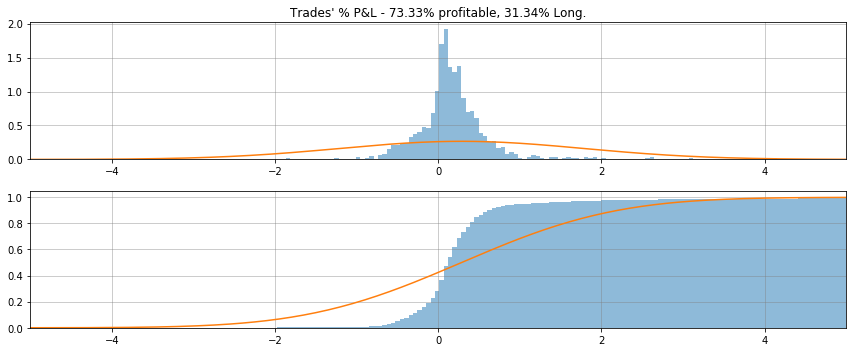

In [742]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(12, 5))

tit = "Trades' % P&L - " + str(int(10000 * (trades_df.PL > 0).mean())/100) + '% profitable, '
tit += str(int(10000 * (trades_df.Amount > 0).mean())/100) + '% Long.'
plt.subplot(211)
plt.title(tit)
trades_df.PL_pct.hist(cumulative=False, density=1, bins=1000, alpha=0.5)
plt.plot(np.arange(-10, 10, 0.05), stats.norm.pdf(np.arange(-10, 10, 0.05),
                                                  loc=trades_df.PL_pct.mean(),
                                                  scale=trades_df.PL_pct.std()))
plt.grid(c='grey', alpha=0.5)
plt.xlim((-5, 5))

plt.subplot(212)
trades_df.PL_pct.hist(cumulative=True, density=1, bins=1000, alpha=0.5)
plt.plot(np.arange(-10, 10, 0.05), stats.norm.cdf(np.arange(-10, 10, 0.05),
                                                  loc=trades_df.PL_pct.mean(),
                                                  scale=trades_df.PL_pct.std()))
plt.grid(c='grey', alpha=0.5)
plt.xlim((-5, 5))
plt.tight_layout()
plt.show()

# Data transforms for learning

In [ ]:
ticker = np.random.choice(tickers)
price = prices.loc[ticker]
print(ticker, len(price), 'days.')

In [ ]:
df = price
tr = find_trends(df)
tr = tr[['Open', 'High', 'Low', 'Close', 'Volume', 'Set', 'Trend', 'Max_Drawdown', 'ATR', 'ICAGR']]
tr = tr.assign(Ch = tr.Close.pct_change().add(1).apply('log'))
tr = tr.assign(Ch2 = tr.Ch.pow(2), Ch3 = tr.Ch.pow(3), Ch4 = tr.Ch.pow(4))

In [ ]:
tr

In [ ]:
def transform_trends(df, sd=15):
    tr = find_trends(df, sd)
    tr = tr.loc

# TO DO:

1. Better estimation of stop_loss_pct.  Sometimes, the trend period's max_drawdown of the Close is too small.  Include High and Low in the calculation.  (c.f. ATR)
1. Determine the equivalence between SMA and lagged gaussian filter (which lag?).
1. Asset selection.
  * By small or negative change correlations.
  * Highest signal to noise ratios (see Kaufman, 2005, pp. 870).
1. Exit by volume (~extreme reduction, bankrupt, ...).
1. Feature engineering.
  * c.f. fast.ai's `add_datepart` function.
